# Queue code

This is the code of the FIFO Queue Basic Model for High Frequency Trading, solved with Monte Carlo and Quasi Monte Carlo Methods.

Here we import the libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import qmcpy as qp
import math

import warnings
warnings.filterwarnings("ignore")

from IPython.display import clear_output

print("done")

done


Here we have a function that takes a number and gives you the next power of two. It is used for Digital Nets in Base 2 sequences.

In [2]:
def pot2(num):
    pot = math.ceil(math.log2(num))  # Encuentra el exponente de la potencia de 2 más cercana
    pot2 = 2 ** pot # Calcula la potencia de 2 correspondiente
    return pot2

print("done")

done


Here we have the queue function. You have to introduce the number of batches (K), the numbers per batch (J) and the typ of QMC or MC method (rv_type). It returns the solution over the iterations (mean_table) and all the solutions (t_table) for each scenario and iteration, so you can make a histogram.

In [3]:
def queue(J, K, rv_type, print1):
    
    # To avoid errors
    J = int(J)
    K = int(K)
    
    N = J * K # Total number of iterations
    
    Px = 0.2 # Probability of execution
    Pc = 0.3 # Probability of cancellation
    Pa = 0.5 # Probability of addition
    bs = 2.7 # average size of the order
    Q0 = 31 # initial lenght of the queue
    q0 = 31 # initial position of our order
    
    
    d = 120 # The maximum number of orders allowed to being executed
    
    
    t_table = [] # the number of events for being executed in all scenarios
    mean_table = [] # the cumulative average number of events for being executed in each scenario
  

    # Here is chosen the MC or QMC Method:
    if rv_type == 'MC':
        # Normal MC
        rv = np.random.uniform(0, 1, size = [pot2(N), 3*d]) # In MC is not necessary to do this but I do it to compare it fairly with DN2
               
    elif rv_type == 'QMC_Lat':
        # Lattice random variable generation
        lat = qp.Lattice(3*d)
        rv = lat.gen_samples(N)
                
    elif rv_type == 'QMC_DN2':
        # Digital Net random variable generation
        dig = qp.DigitalNetB2(3*d)
        rv = dig.gen_samples(pot2(N))
        
    elif rv_type == 'QMC_Lat_Batch':
        # Lattice random variable generation
        d_batch = int(3*d/K)
        lat = qp.Lattice(d_batch)
        rv = lat.gen_samples(pot2(N)) # In Lattice is not necessary to do this but I do it to compare it fairly with DN2
        for ii in range(K-1):
            lat = qp.Lattice(d_batch)
            rv = np.concatenate((rv, lat.gen_samples(pot2(N))), 1)
        
    elif rv_type == 'QMC_DN2_Batch':
        # Digital Net random variable generation
        d_batch = int(3*d/K)
        dig = qp.DigitalNetB2(d_batch)
        rv = dig.gen_samples(pot2(N))
        for ii in range(K-1):
            dig = qp.DigitalNetB2(d_batch)
            rv = np.concatenate((rv, dig.gen_samples(pot2(N))), 1)
    
    else:
        print('error: Method type non valid')
    
    for ii in range(0, N):

        q = q0
        Q = Q0
        
        
        for t in range(0, d):
            rv0 = rv[ii][3*t] # choosing the type of action
            rv1 = rv[ii][3*t+1] # choosing the size of the order
            rv2 = rv[ii][3*t+2] # choosing where the cancellation is
            
            # ALGORITHM
            size = np.ceil(np.log(rv1)/np.log(1-1/bs))
            if rv0 < Px:
                type_event = 'execution'
                Q = Q - size
                q = q - size
                
            elif rv0 < Px + Pc:
                type_event = 'cancelation'
                if rv2 < q/Q:
                    if size < q: # we cannot be executed by an external cancellation
                        Q = Q - size
                        q = q - size
                else:
                    if q + size < Q: # q cannot be gretaer than Q!!!! if so, ignore the cancelation
                        Q = Q - size
                
            else: 
                type_event = 'addition'
                Q = Q + size
                q = q
        
            if q <= 0:
                t_table.append(t)
                mean_table.append(np.mean(t_table))
                break
                      
    if print1 == 1:        
        # Print of means
        if rv_type == 'MC':
            print("MC mean is: " + str(np.mean(t_table)))
        elif rv_type == 'QMC_Lat':
            print("QMC Lattice is: " + str(np.mean(t_table)))
        elif rv_type == 'QMC_DN2':
            print("QMC Digital Net is: " + str(np.mean(t_table)))
        elif rv_type == 'QMC_Lat_Batch':
            print("QMC Lattice with " + str(K) + " batches is: " + str(np.mean(t_table)))
        elif rv_type == 'QMC_DN2_Batch':
            print("QMC Digital Net with " + str(K) + " batches is: " + str(np.mean(t_table)))
    
 
    return mean_table, t_table
    print()
    
print("done")

done


Here we obtain the "real solution" using MC and a big number of iterations. The we use the moving average to avoid fluctuations.

In [4]:
J = 20000
K = 1 # In MC the batches are not important because there is no autocorrelation in the random sequence
sol_register = [] # array for saving the solutions

experiments = 20 # number of times the experiment is repeated, number of solutions registered

for ii in range(experiments):
    sol_aux = queue(J, K, 'MC', 0)[0][-1] # the mean is to reduce fluctuations (moving average)
    sol_register.append(sol_aux)
    
sol = np.mean(sol_register) # solution

sol_std = np.std(sol_register) # std of the solution

sol_range = np.ceil(2.58*1.2*sol_std/np.sqrt(experiments)) # length of the confidence semi interval

lower_bound = sol - sol_range # lower bound of the confidence interval

upper_bound = sol + sol_range # upper bound of the confidence interval

print('The solution is going to be: ' + str(sol) + ', with a 95% confidence interval: (' + str(lower_bound) + ', ' + str(upper_bound) + ')')

print("done")

The solution is going to be: 36.552690569868034, with a 95% confidence interval: (35.552690569868034, 37.552690569868034)
done


The solution is going to be: 36.552690569868034, with a 95% confidence interval: (35.552690569868034, 37.552690569868034)

experiments = 200 in that

Here we run the program for the different MC and QMC methods. Batches are not important. We assume only one batch. We want to know if QMC converges.

In [5]:
K = 1 # number of batches
J = 8000 # number of times per batch the simulation is run

rv_table = ['MC', 'QMC_Lat', 'QMC_DN2'] # Here the number of batches is not important (then, it will matter)

mean_table = []
t_table = []

for jj in range(0, len(rv_table)):
    rv_type = rv_table[jj]
    
    [mean_aux, hist_aux] = queue(J, K, rv_type, 1)
    
    mean_table.append(mean_aux)
    t_table.append(hist_aux)

sol = np.ones(J*K) * sol
    
print("done")

MC mean is: 36.733625
QMC Lattice is: 36.65575
QMC Digital Net is: 36.533
done


Here we draw the convergence plot of the different methods from the first iteration until the last one. 

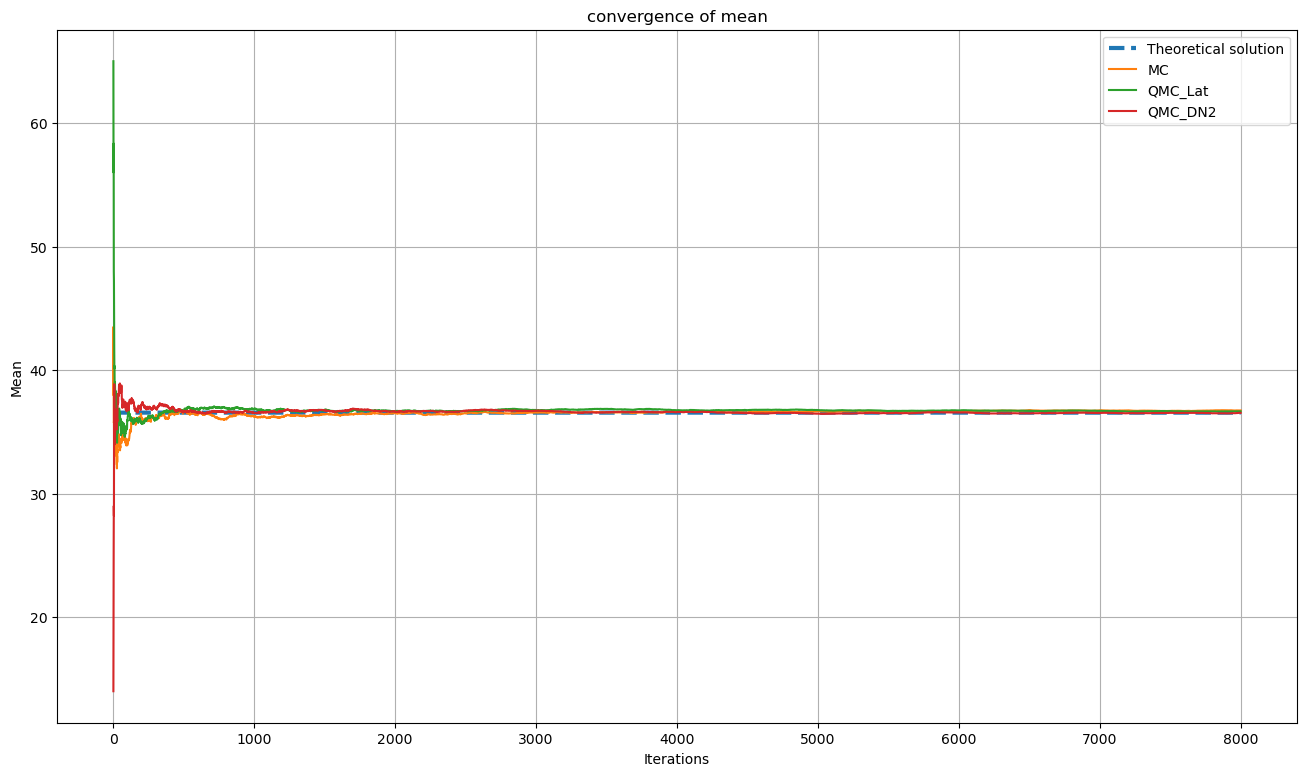

done


In [6]:
# plot of convergence
fig, ax = plt.subplots(figsize=[16, 9])
ax.set_title("convergence of mean")
ax.set_xlabel("Iterations")
ax.set_ylabel("Mean")
plt.grid(True)

plt.plot(sol[:J*K], linewidth=3, linestyle='--', label = 'Theoretical solution')

for jj in range(0, len(rv_table)):
    rv_type = rv_table[jj]
    
    plt.plot(mean_table[jj], label = rv_type)
plt.legend()   
plt.show()

print("done")

Here we plot the different histograms of all the solutions in all the scenarios in Logscale. The idea is to minimize the fluctuations in the first iteractions.

# it doesn't seem better(?)

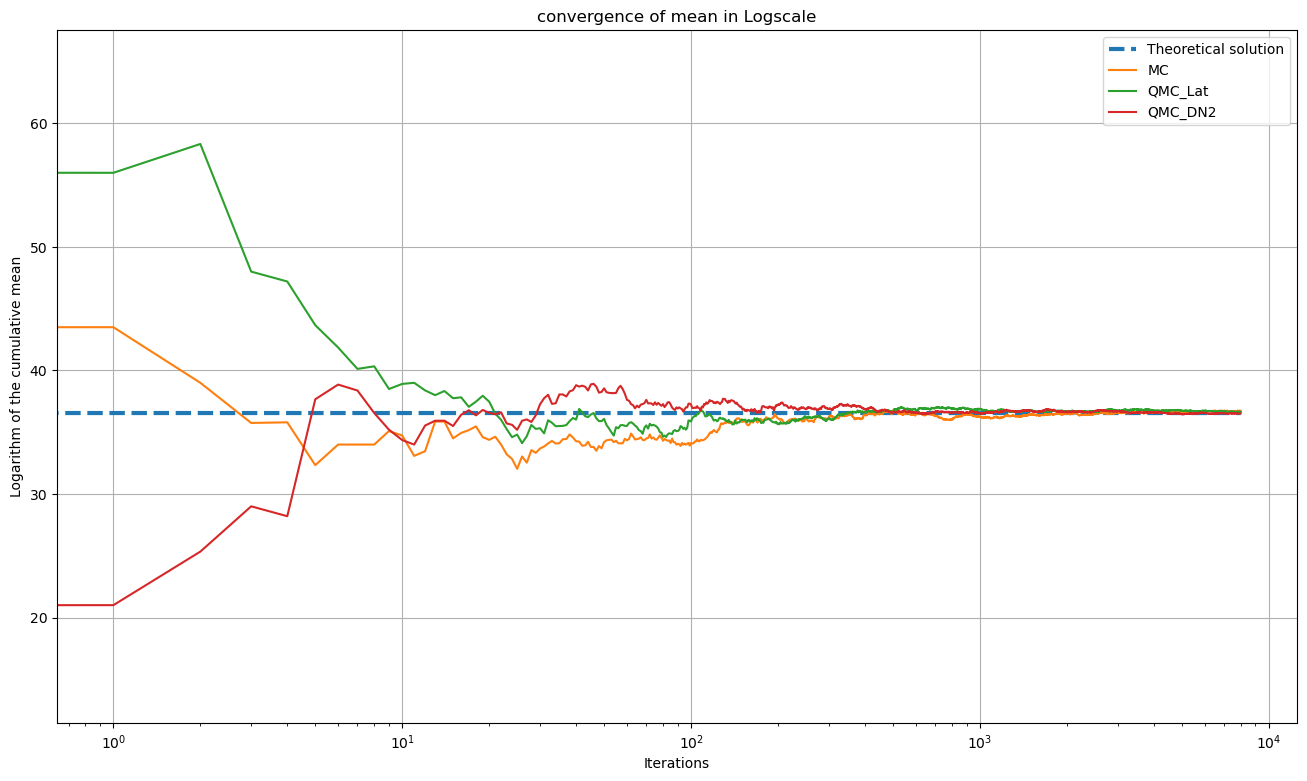

done


In [7]:
# plot of convergence in logscale
fig, ax = plt.subplots(figsize=[16, 9])
ax.set_title("convergence of mean in Logscale")
ax.set_xlabel("Iterations")
ax.set_ylabel("Logarithm of the cumulative mean")
plt.grid(True)



plt.plot(sol[:J*K], linewidth=3, linestyle='--', label = 'Theoretical solution')

for jj in range(0, len(rv_table)):
    rv_type = rv_table[jj]
    
    plt.plot(mean_table[jj], label = rv_type)
plt.legend()   
plt.xscale('log')
plt.show()

print("done")

And here we plot the different histograms of all the solutions in all the scenarios. In the top left graphic we can see the same plot as before from iteration 0 to iteration 400.

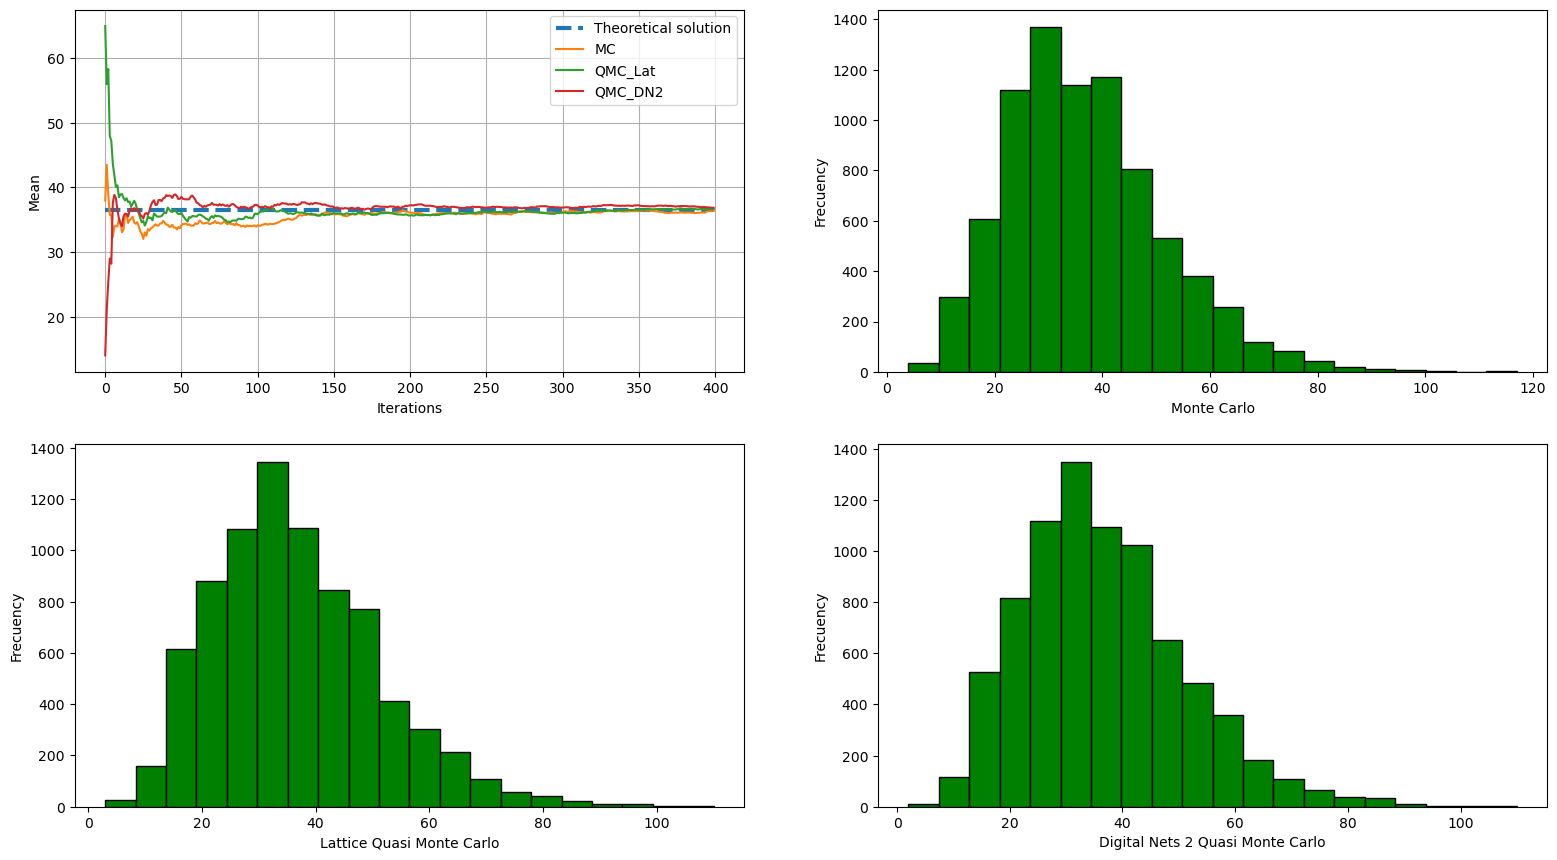

done


In [8]:
# Plot of Histograms
fig, ax = plt.subplots(figsize=[19, 16])

plt.subplot(3, 2, 1)
plt.xlabel("Iterations")
plt.ylabel("Mean")
plt.grid(True)

plt.plot(sol[0 : 400], linewidth=3, linestyle='--', label = 'Theoretical solution')

for jj in range(0, len(rv_table)):
    rv_type = rv_table[jj]
    
    plt.plot(mean_table[jj][0 : 400], label = rv_type)
plt.legend()   
 
for jj in range(0, len(rv_table)):
    rv_type = rv_table[jj]

    plt.subplot(3, 2, jj+2)
    if rv_type == 'MC':
        plt.xlabel("Monte Carlo")    
    elif rv_type == 'QMC_Lat':
        plt.xlabel("Lattice Quasi Monte Carlo")
    elif rv_type == 'QMC_DN2':
        plt.xlabel("Digital Nets 2 Quasi Monte Carlo")
    elif rv_type == 'QMC_Lat_Batch':
        plt.xlabel("Lattice Quasi Monte Carlo with " + str(K) + " batches")
    elif rv_type == 'QMC_DN2_Batch':
        plt.xlabel("Digital Nets 2 Quasi Monte Carlo with " + str(K) + " batches")
    plt.ylabel("Frecuency")
    plt.hist(t_table[jj], bins=20, alpha=1, color="green", edgecolor='black', linewidth=1)
  
plt.show()

print("done")

Here we can see the first 200 iterations for the convergence plot.

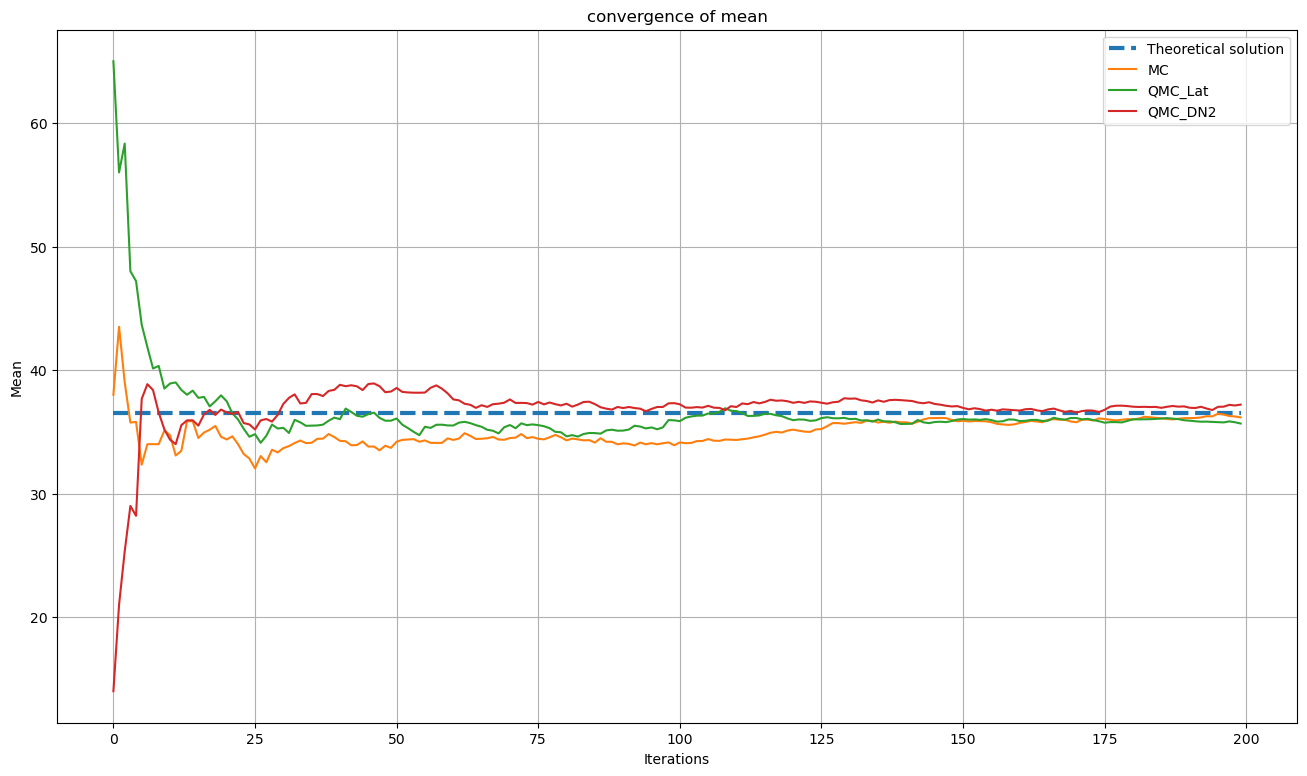

done


In [9]:
# plot of convergence
fig, ax = plt.subplots(figsize=[16, 9])
ax.set_title("convergence of mean")
ax.set_xlabel("Iterations")
ax.set_ylabel("Mean")
plt.grid(True)

plt.plot(sol[0:200], linewidth=3, linestyle='--', label = 'Theoretical solution')

for jj in range(0, len(rv_table)):
    rv_type = rv_table[jj]
    
    plt.plot(mean_table[jj][0:200], label = rv_type)
plt.legend()   
plt.show()

print("done")

And here we can see the iteration 25 to the 2025. It is made to avoid the initial peaks. In the first iterations is really probable to have solutions with errors of 20% or more, this can distorsionate the axis view of the plot. We can avoid that not plotting the first steps.

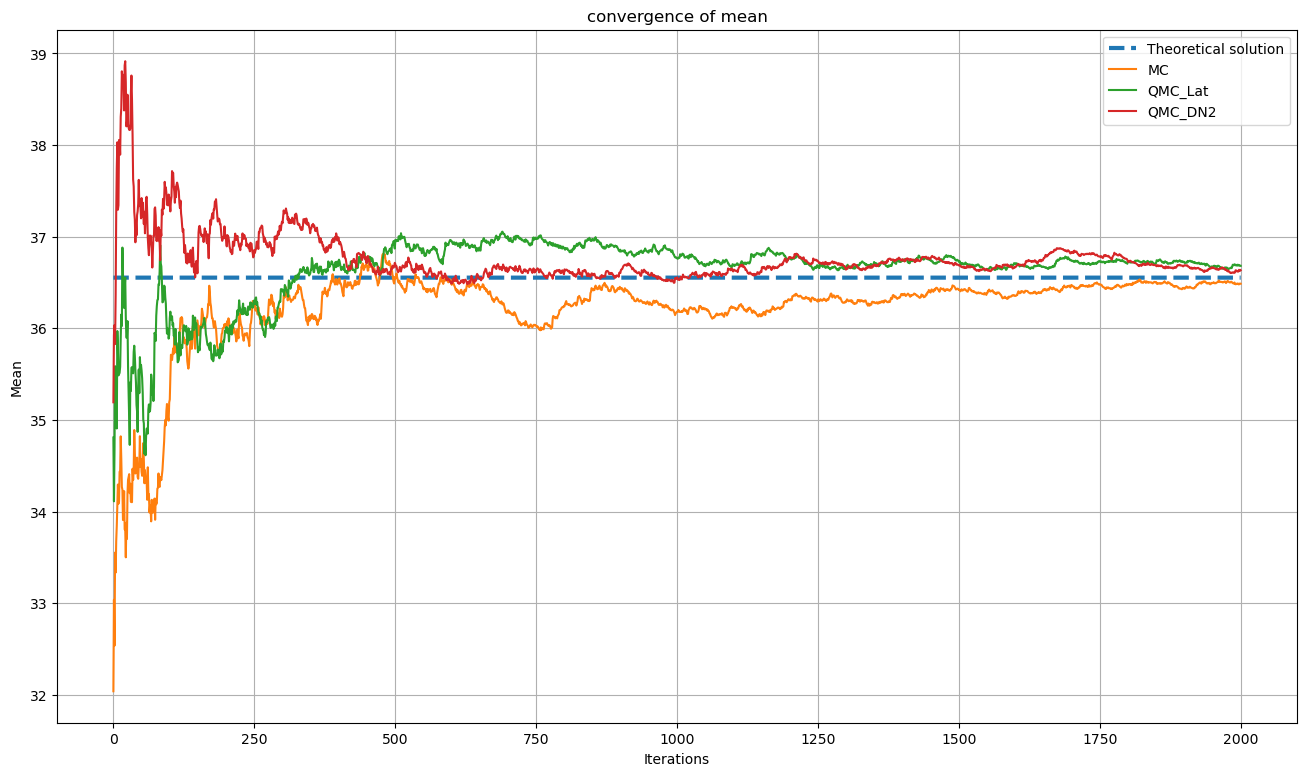

done


In [10]:
# plot of convergence
fig, ax = plt.subplots(figsize=[16, 9])
ax.set_title("convergence of mean")
ax.set_xlabel("Iterations")
ax.set_ylabel("Mean")
plt.grid(True)

plt.plot(sol[25:2025], linewidth=3, linestyle='--', label = 'Theoretical solution')

for jj in range(0, len(rv_table)):
    rv_type = rv_table[jj]
    
    plt.plot(mean_table[jj][25:2025], label = rv_type)
plt.legend()   
plt.show()

print("done")

Here we are going to try different baches for QMC methods.

In [11]:
J_array = [] # iterations per batch
K_array = [] # number of batches
mean_table = [] # cummulative average through scenarios
t_table = [] # all scenarios
J_max = 2400 # Maximum number per batch
K_array = [1, 5, 10, 30, 60, 120] # Different size of batches

for kk in range(len(K_array)):
        J_array.append(int(J_max/K_array[kk])) # All the QMC have the same N

        K = K_array[kk] # number of batches
        J = J_array[kk] # number of times per batch the simulation is run

        rv_table = ['QMC_DN2_Batch', 'QMC_Lat_Batch']

        for jj in range(0, len(rv_table)):
            rv_type = rv_table[jj]

            [mean_aux, hist_aux] = queue(J, K, rv_type, 1)

            mean_table.append(mean_aux)
            t_table.append(hist_aux)
         
# adding a MC method to compare it
[mean_aux, hist_aux] = queue(J, K, 'MC', 1)

mean_table.append(mean_aux)
t_table.append(hist_aux)

print('done')

QMC Digital Net with 1 batches is: 36.52291666666667
QMC Lattice with 1 batches is: 36.47875
QMC Digital Net with 5 batches is: 36.557916666666664
QMC Lattice with 5 batches is: 36.04416666666667
QMC Digital Net with 10 batches is: 36.05875
QMC Lattice with 10 batches is: 36.55166666666667
QMC Digital Net with 30 batches is: 36.125416666666666
QMC Lattice with 30 batches is: 36.56666666666667
QMC Digital Net with 60 batches is: 36.7425
QMC Lattice with 60 batches is: 36.16916666666667
QMC Digital Net with 120 batches is: 34.031666666666666
QMC Lattice with 120 batches is: 35.815416666666664
MC mean is: 36.50791666666667
done


Here we draw the convergence plot through scenarios from iteration 25 to iteration J_max (2400).

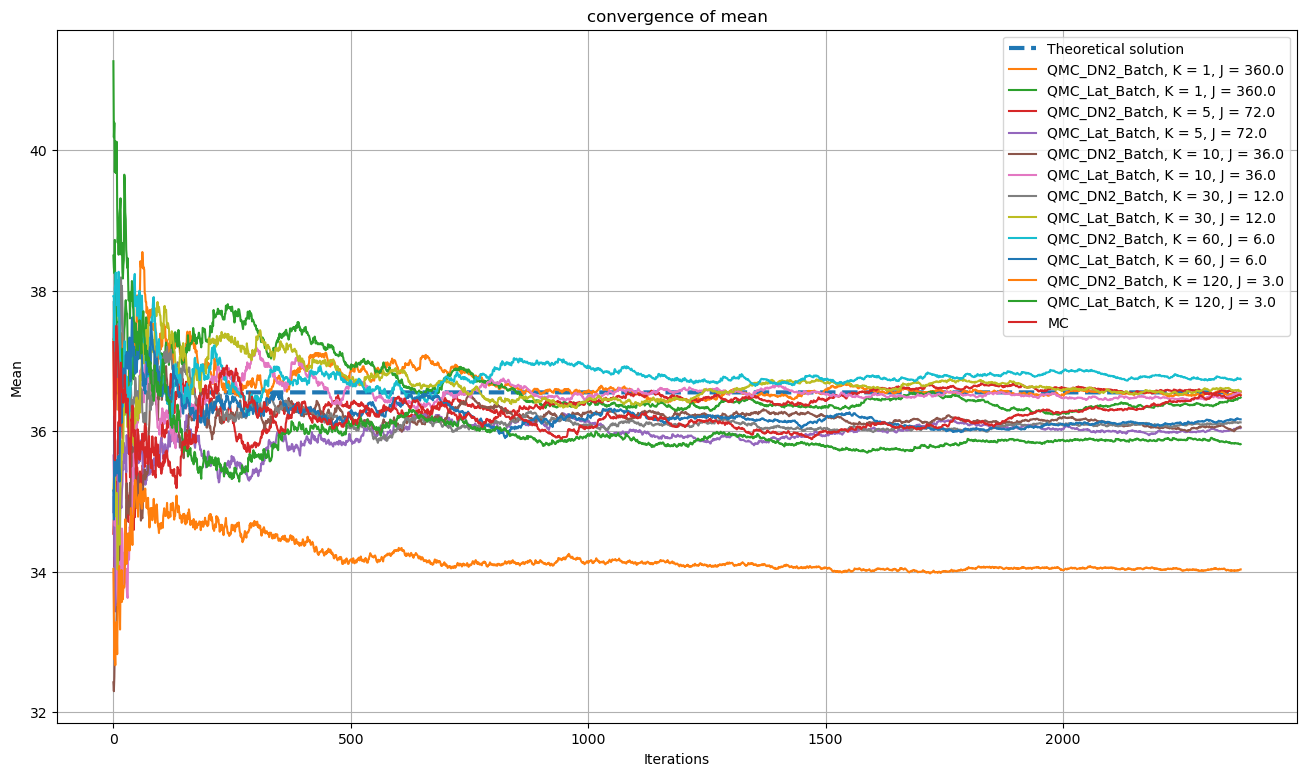

done


In [12]:
# plot of convergence
fig, ax = plt.subplots(figsize=[16, 9])
ax.set_title("convergence of mean")
ax.set_xlabel("Iterations")
ax.set_ylabel("Mean")
plt.grid(True)

plt.plot(sol[50:J_max], linewidth=3, linestyle='--', label = 'Theoretical solution')

aux = 0
for kk in range(len(K_array)):
    
 
    for jj in range(0, len(rv_table)):
        rv_type = rv_table[jj]
        
        plt.plot(mean_table[aux][25:J_max], label = rv_table[jj] + ', K = ' + str(K_array[kk]) + ', J = ' + str(360/K_array[kk]))
        
        aux = aux + 1
        
plt.plot(mean_table[-1][25:J_max], label = 'MC')
    
plt.legend(loc='upper right')
plt.show()

print('done')

The logical number of batches should be bewteen 10 (that means discrepancy sequences of 36 [360/10]) numbers and 36 (10 [360/36]).

In [13]:
J_array = [] # iterations per batch
K_array = [] # number of batches
mean_table = [] # cummulative average through scenarios
t_table = [] # all scenarios
J_max = 2400 # Maximum number per batch
K_array = [10, 12, 15, 18, 20, 24, 30, 36] # Different size of batches

for kk in range(len(K_array)):
        J_array.append(int(J_max/K_array[kk])) # All the QMC have the same N

        K = K_array[kk] # number of batches
        J = J_array[kk] # number of times per batch the simulation is run

        rv_table = ['QMC_DN2_Batch', 'QMC_Lat_Batch']

        for jj in range(0, len(rv_table)):
            rv_type = rv_table[jj]

            [mean_aux, hist_aux] = queue(J, K, rv_type, 1)

            mean_table.append(mean_aux)
            t_table.append(hist_aux)
         
# adding a MC method to compare it
[mean_aux, hist_aux] = queue(J, K, 'MC', 1)

mean_table.append(mean_aux)
t_table.append(hist_aux)

print('done')

QMC Digital Net with 10 batches is: 35.736666666666665
QMC Lattice with 10 batches is: 36.19
QMC Digital Net with 12 batches is: 36.54625
QMC Lattice with 12 batches is: 37.09791666666667
QMC Digital Net with 15 batches is: 37.02458333333333
QMC Lattice with 15 batches is: 36.38166666666667
QMC Digital Net with 18 batches is: 36.69256474519632
QMC Lattice with 18 batches is: 37.04805683242792
QMC Digital Net with 20 batches is: 36.86666666666667
QMC Lattice with 20 batches is: 36.660833333333336
QMC Digital Net with 24 batches is: 35.892916666666665
QMC Lattice with 24 batches is: 37.2475
QMC Digital Net with 30 batches is: 36.4375
QMC Lattice with 30 batches is: 37.37291666666667
QMC Digital Net with 36 batches is: 36.648989898989896
QMC Lattice with 36 batches is: 35.61700336700337
MC mean is: 36.514309764309765
done


Here we can see how they converge:

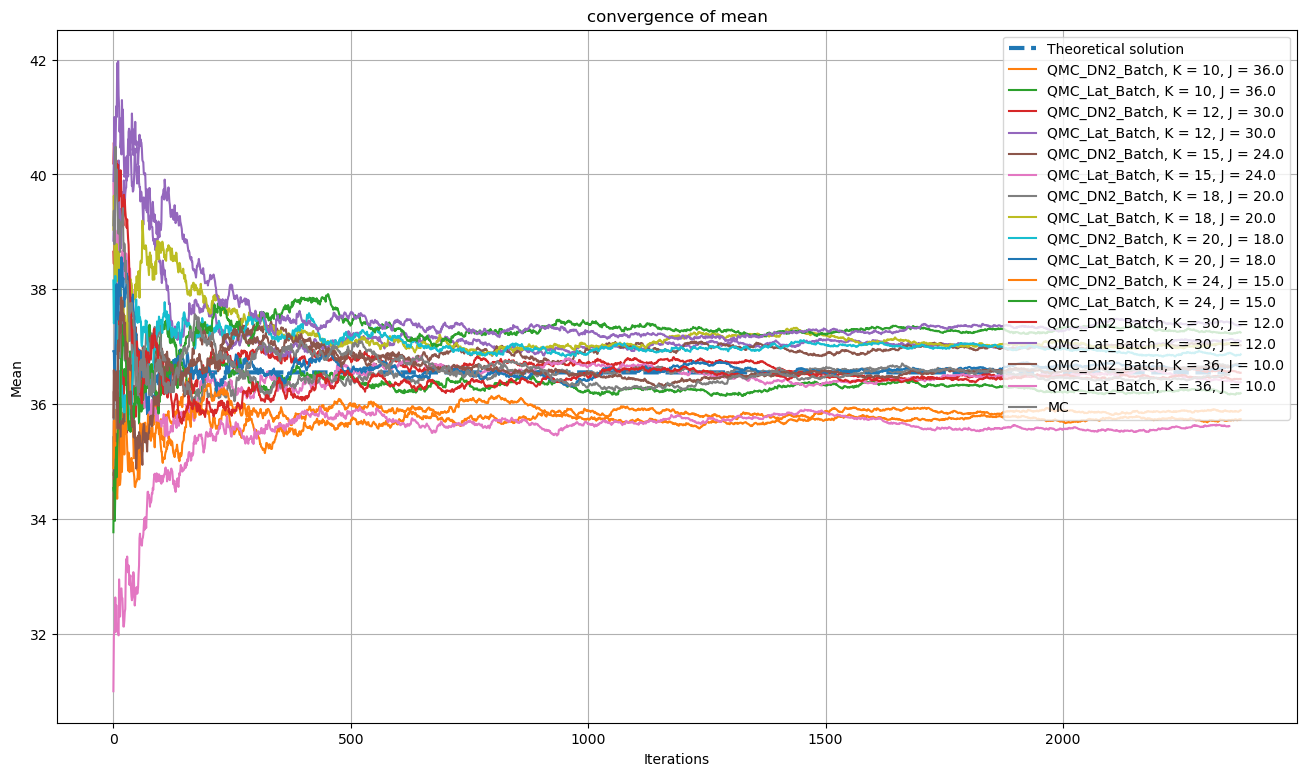

done


In [14]:
# plot of convergence
fig, ax = plt.subplots(figsize=[16, 9])
ax.set_title("convergence of mean")
ax.set_xlabel("Iterations")
ax.set_ylabel("Mean")
plt.grid(True)

plt.plot(sol[50:J_max], linewidth=3, linestyle='--', label = 'Theoretical solution')

aux = 0
for kk in range(len(K_array)):
    
 
    for jj in range(0, len(rv_table)):
        rv_type = rv_table[jj]
        
        plt.plot(mean_table[aux][25:J_max], label = rv_table[jj] + ', K = ' + str(K_array[kk]) + ', J = ' + str(360/K_array[kk]))
        
        aux = aux + 1
        
plt.plot(mean_table[-1][25:J_max], label = 'MC')
    
plt.legend(loc='upper right')
plt.show()

print('done')

Here we can see a test to see how good are the QMC method solutions:

In [15]:
experiments = 30 # number of times the experiment is repeated, number of solutions registered
mean_register = []
rv_table = ['QMC_DN2_Batch', 'QMC_Lat_Batch']
for jj in range(0, len(rv_table)):
    mean_register.append([])
    for ii in range(experiments):
        mean_register[jj].append([])
    
J_array = [] # iterations per batch
K_array = [] # number of batches
mean_table = [] # cummulative average through scenarios
t_table = [] # all scenarios
J_max = 2400 # Maximum number per batch
K_array = [10, 12, 15, 18, 20, 24, 30, 36] # Different size of batches

for kk in range(len(K_array)):
    J_array.append(int(J_max/K_array[kk])) # All the QMC have the same N

    K = K_array[kk] # number of batches
    J = J_array[kk] # number of times per batch the simulation is run

    for jj in range(0, len(rv_table)):
        rv_type = rv_table[jj]
        for ii in range(experiments):
            mean_register[jj][ii].append(queue(J, K, rv_type, 0)[0][-1])
        
        sol_register = np.mean(mean_register[jj]) # solution

        sol_std = np.std(mean_register[jj]) # std of the solution

        sol_range = np.ceil(2.58*1.2*sol_std/np.sqrt(experiments)) # length of the confidence semi interval
    
        lower_bound = sol_register - sol_range # lower bound of the confidence interval
    
        upper_bound = sol_register + sol_range # upper bound of the confidence interval
    
        print('The solution for ' + rv_table[jj] + ' with ' + str(K_array[kk]) + ' bacthes is going to be: ' + str(sol_register) + ', with a 95% confidence interval: (' + str(lower_bound) + ', ' + str(upper_bound) + ')')

            

print('done')

The solution for QMC_DN2_Batch with 10 bacthes is going to be: 36.60399428233697, with a 95% confidence interval: (35.60399428233697, 37.60399428233697)
The solution for QMC_Lat_Batch with 10 bacthes is going to be: 36.55268924551897, with a 95% confidence interval: (35.55268924551897, 37.55268924551897)
The solution for QMC_DN2_Batch with 12 bacthes is going to be: 36.62533039923897, with a 95% confidence interval: (35.62533039923897, 37.62533039923897)
The solution for QMC_Lat_Batch with 12 bacthes is going to be: 36.592802860679214, with a 95% confidence interval: (35.592802860679214, 37.592802860679214)
The solution for QMC_DN2_Batch with 15 bacthes is going to be: 36.6209223353085, with a 95% confidence interval: (35.6209223353085, 37.6209223353085)
The solution for QMC_Lat_Batch with 15 bacthes is going to be: 36.62724201256465, with a 95% confidence interval: (35.62724201256465, 37.62724201256465)
The solution for QMC_DN2_Batch with 18 bacthes is going to be: 36.58198102657979, 

Things changed until this point:

1) 20 replications for the real solution, so there's a confidence interval of it. (should it be a t-test or a nomral test?)

2) Doing a convergence plot in logscale.

3) do the experiment for 10 to 20 batches of the divisors of 360.

4) Doing all scenarios for QMC methods a power of 2 so we can compare DN2 with Lattice.

5) std of all scenarios to make a t-test. I didn't understand it quite well. Should it be the same method as the "real solution" one? (I mean, repeat the 2400 scenarios 20 times and then do the confidence interval because the solution of each experiment is iid with the others).
